# `probly` Tutorial — Bayesian Transformation 

This notebook is a practical introduction to the Bayesian transformation in `probly`. Bayesian Neural Networks are a more advanced topic than Dropout or DropConnect,
so this tutorial aims to provide an intuitive, hands-on understanding.

We will start by explaining the core idea behind Bayesian Neural Networks (BNNs) and then see how the `probly` transformation enables you to create them. After that, we will look at a PyTorch example to inspect the transformed model and use it to estimate uncertainty.

---
# Part A: Introduction to BNNs and the Bayesian Transformation
---


## 1.Concept: What is a Bayesian Neural Network?

To understand the Bayesian transformation, we first need to understand the difference between a standard neural network and a Bayesian one.

### 1.1 Standard Neural Networks

In a standard neural network, each weight is a single, deterministic number. After training, these weights are fixed. 
When you pass an input through the model, it follows one exact path, producing one exact output.
The model has no inherent way to express how "sure" it is about the values of its weights.

### 1.2 Bayesian Neural Networks (BNNs)

In a Bayesian Neural Network, we replace the deterministic weights with probability distributions.
Instead of a weight being a single number, it might be represented by a Gaussian (normal) distribution 
with a mean and a standard deviation.

- The mean represents the most likely value for that weight.

- The standard deviation represents the model's uncertainty about that weight. A small standard deviation means the model
 is very confident in the weight's value, while a large one means it is very unsure.

During a forward pass, we don't use the mean value directly. Instead, we sample a value for each weight from its distribution.
Because we get a slightly different set of weights every time, each forward pass on the same input will produce a slightly different
 output. This natural variation is a direct reflection of the model's parameter uncertainty.

### 1.3 The Bayesian Transformation `(probly)`

The Bayesian transformation in `probly` automates the process of converting a standard network into a BNN.

The transformation does the following:

It walks through your PyTorch model and finds all compatible layers (e.g., nn.Linear and nn.Conv2d).
It programmatically replaces each standard layer with a corresponding custom Bayesian layer (e.g., BayesLinear, BayesConv2d).
These new layers contain weight distributions instead of single values and are inherently stochastic, even during inference.

This allows us to get a distribution of predictions by running multiple forward passes, which we can then use to quantify the model's uncertainty.


### 1.4. What that entails
| Aspect                       |Bayesian Transformation `(probly)`                                                |
|------------------------------|--------------------------------------------------------                          |
| **Main Idea**                | "Weights are distributions"                                                      | 
| Stochastic Element           | Weights are sampled from probability distributions.                              | 
| Architectural Change         | Replaces `nn.Linear` and `nn.Conv2d` with `BayesLinear`/`BayesConv2d` layers.    | 
| Uncertainty Interpretation   | A principled, direct measure of the model's parameter uncertainty.               | 
|Supported Layers              | `Linear` and `Conv2d`                                                            | 
|Key Parameters                | `prior_mean`, `prior_std`, `posterior_std`                                       | 

## 2. Quickstart (PyTorch)

Below: build a small MLP, apply `bayesian(model)`, and inspect the modified architecture to see the layer replacement.


In [2]:
import torch
from torch import nn

from probly.transformation import bayesian


def build_mlp(in_dim: int = 10, hidden: int = 32, out_dim: int = 1) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(in_dim, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, out_dim),
    )


model = build_mlp()
print("Original model:\n", model)

# Apply the Bayesian transformation with default parameters
model_bnn = bayesian(model)
print(f"\nWith Bayesian transformation:\n", model_bnn)

Original model:
 Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

With Bayesian transformation:
 Sequential(
  (0): BayesLinear()
  (1): ReLU()
  (2): BayesLinear()
  (3): ReLU()
  (4): BayesLinear()
)


#### Notes on the structure

- Notice that each `Linear` layer has been replaced by a `BayesLinear` layer.
- The new layers manage the distributions for the weights and biases internally.

## 3. Uncertainty via Stochastic Forward Passes

To obtain predictive uncertainty, we run multiple forward passes. In each pass, a new set of weights is sampled from the learned distributions.
We then compute the mean and variance of the resulting predictions.

In [3]:
# Toy regression data
torch.manual_seed(0)
n = 128
X = torch.randn(n, 10)
true_w = torch.randn(10, 1)
y = X @ true_w + 0.1 * torch.randn(n, 1)

# Build and transform the model
model = build_mlp(in_dim=10, hidden=64, out_dim=1)
model_bnn = bayesian(model)

# Simple training loop (for illustration)
opt = torch.optim.Adam(model_bnn.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

for _step in range(200):
    opt.zero_grad()
    pred = model_bnn(X)
    loss = loss_fn(pred, y)
    loss.backward()
    opt.step()


# Prediction function (stochastic passes)
@torch.no_grad()
def stochastic_predict(
    bayesian_model: nn.Module,
    inputs: torch.Tensor,
    n_samples: int = 50,
) -> tuple[torch.Tensor, torch.Tensor]:
    preds = []
    for _ in range(n_samples):
        preds.append(bayesian_model(inputs).detach())
    stacked = torch.stack(preds, dim=0)  # [n_samples, N, out_dim]
    mean = stacked.mean(dim=0)
    var = stacked.var(dim=0, unbiased=False)
    return mean, var


mean_pred, var_pred = stochastic_predict(model_bnn, X[:5], n_samples=100)
print("Predictive mean (first 5):\n", mean_pred.squeeze())
print("\nPredictive variance (first 5):\n", var_pred.squeeze())

Predictive mean (first 5):
 tensor([-1.1153,  3.2737,  1.8071, -1.3878, -0.6908])

Predictive variance (first 5):
 tensor([0.0594, 0.0913, 0.0668, 0.0288, 0.0506])


## 4. Part A Summary

In Part A, we introduced the core concept of Bayesian Neural Networks, where weights are represented as probability distributions rather than single numbers.
This inherently captures the model's uncertainty about its own parameters. We saw how the `probly.transformation.bayesian` Bayesian Transformation makes creating BNNs simple: 
it traverses a standard PyTorch model and replaces `nn.Linear` and `nn.Conv2d` layers with their Bayesian counterparts. This transformed model naturally producesIn Part A, 
we introduced the core concept of Bayesian Neural Networks, where weights are represented as probability distributions rather than single numbers.
This inherently captures the model's uncertainty about its own parameters. We saw how the probly Bayesian Transformation makes creating BNNs simple: 
it traverses a standard PyTorch model and replaces nn.Linear and nn.Conv2d layers with their Bayesian counterparts. This transformed model naturally
produces a distribution of outputs for any given input, allowing us to directly quantify predictive uncertainty. a distribution of outputs for any given input, 
allowing us to directly quantify predictive uncertainty.

---

# Part B — Applied BNN Transformation
--- 

In Part A, we learned what the Bayesian transformation in `probly` does.
In this Part B, we will apply it to a model containing both linear and convolutional layers, run several stochastic predictions, and visualize the resulting uncertainty.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from probly.transformation import bayesian

torch.manual_seed(42)


class TinyConvNet(nn.Module):
    """A tiny CNN for demonstration."""

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1) # 28x28 -> 14x14
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 14 * 14, 32)
        self.out = nn.Linear(32, 10) # For 10 classes

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.out(x)


# dummy input (e.g., MNIST-like)
x = torch.randn(1, 1, 28, 28)
base_model = TinyConvNet().eval()

## 2. Apply the Bayesian transformation

We now transform the base model with `bayesian()`. This will replace both its `nn.Linear` and `nn.Conv2d` layers.

In [11]:
bnn_model = bayesian(base_model)
bnn_model.train()  # Enable stochasticity
bnn_model.eval()

TinyConvNet(
  (conv1): BayesConv2d()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): BayesLinear()
  (out): BayesLinear()
)

## 3. Stochastic inference: repeated forward passes

We feed the same input through the model multiple times and collect the stochastic outputs.

In [12]:
num_passes = 100
logits_list = []

with torch.no_grad():
    for _ in range(num_passes):
        logits_list.append(bnn_model(x))

logits = torch.cat(logits_list, dim=0)  # [num_passes, 10]
probs = torch.softmax(logits, dim=-1)  # convert to probabilities

## 4. Quantify uncertainty

Compute the mean and standard deviation across all passes — these capture the central tendency and spread (uncertainty).

In [13]:
from probly.quantification import classification as q

# Reshape for probly's quantification functions: [n_instances, n_samples, n_classes]
probs_reshaped = probs.unsqueeze(0)

mean_probs = probs.mean(dim=0)
std_probs = probs.std(dim=0, unbiased=False)

pred_class = mean_probs.argmax().item()
predictive_entropy = q.total_entropy(probs_reshaped).item()

print("Mean probabilities:\n", mean_probs)
print("\nStd probabilities:\n", std_probs)
print("\nPredicted class:", pred_class)
print(f"Predictive entropy: {predictive_entropy:.4f}")

Mean probabilities:
 tensor([0.1490, 0.0903, 0.0841, 0.0602, 0.1028, 0.0871, 0.1397, 0.0701, 0.1674,
        0.0493])

Std probabilities:
 tensor([0.0719, 0.0591, 0.0344, 0.0343, 0.0459, 0.0394, 0.0645, 0.0460, 0.0754,
        0.0265])

Predicted class: 8
Predictive entropy: 3.2223


## 5. Visualization – Inspecting uncertainty distributions

We visualize how much the predicted probabilities fluctuate across stochastic runs.

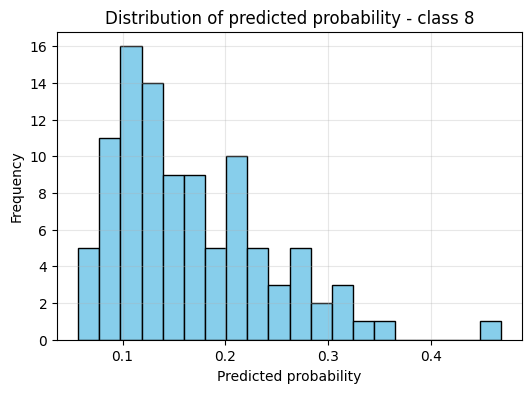

In [14]:
winning_class = int(mean_probs.argmax().item())

plt.figure(figsize=(6, 4))
plt.hist(probs[:, winning_class].numpy(), bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribution of predicted probability - class {winning_class}")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

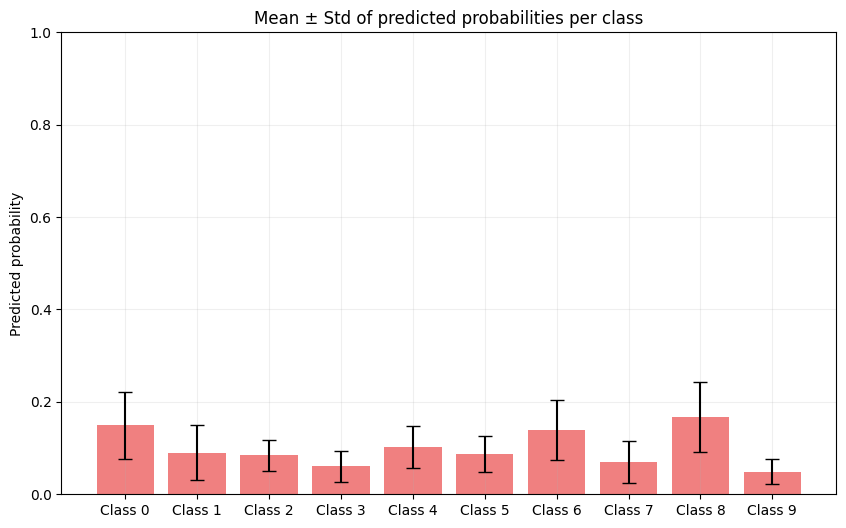

In [25]:
C = mean_probs.shape[0]
plt.figure(figsize=(10, 6))
plt.bar(np.arange(C), mean_probs.numpy(), yerr=std_probs.numpy(), capsize=5, color="lightcoral")
plt.xticks(np.arange(C), [f"Class {i}" for i in range(C)])
plt.ylabel("Predicted probability")
plt.title("Mean ± Std of predicted probabilities per class")
plt.ylim(0, 1)
plt.grid(alpha=0.2)
plt.show()